In [1]:
import os
import pandas as pd
import numpy as np
import glob
import altair as alt
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.dates as mdates
import matplotlib
from pathlib import Path

## Procesamiento de datos

Los datos serán procesados con _pandas_, librería para python utilizada en el análisis de datos. A continuación (celdas 2-5), se cargan los datos, originalmente en formato _.dat_, y se llevan a un _dataframe_, de los cuales se pueden realizar múltiples operaciones que se verán más adelante.

Los datos son obtenidos de un ADV, con _burst intervals_ de 5 minutos cada uno, y mediciones a una frecuencia de 16[Hz]. Esto quiere decir que, se tienen __4.800__ mediciones por _burst_.

In [2]:
all_data_list = glob.glob(os.path.join(r"C:\Users\lukas\Documents\git\msc\zip\ADV_fieldFrames copy\December2017_ADVframes\ADV\Mudflat", "*.dat"))
li = []
for filename in all_data_list:
    df = pd.read_csv(filename, sep='\s+', index_col=None, header=None)
    li.append(df)
all_data = pd.concat(li, axis=0, ignore_index=True)

pressure_filename = r"C:\Users\lukas\Documents\git\msc\zip\ADV_fieldFrames copy\December2017_ADVframes\ADV\Mudflat\MF02.vhd"
pressure_data = pd.read_csv(
    pressure_filename,
    sep='\s{1,}',
    index_col=None,
    engine='python',
    header=None
)

In [3]:
pressure_data.columns = [
    'Month', 'Day', 'Year', 'Hour', 'Minute', 'Second', 'Burst_counter',
    'a1', 'a2', 'a3', 'a4', 'a5', 'a6', 'a7', 'a8', 'a9', 'a10', 'a11', 'a12', 'a13', 'a14', 'a15', 'a16', 'a17'
]

In [4]:
pressure_data_date = pressure_data
pressure_data_date['Date'] = pd.to_datetime(pressure_data[['Year','Month','Day', 'Hour', 'Minute', 'Second']])
pressure_data_date = pressure_data_date[['Date','Burst_counter']].sort_values('Date')

In [5]:
all_data.columns = [
    'Burst_counter', 'Ensemble_counter', 'Velocity_x', 'Velocity_y', 'Velocity_z',
    'Amplitude_1', 'Amplitude_2', 'Amplitude_3', 'SNR_1', 'SNR_2', 'SNR_3',
    'Correlation_1', 'Correlation_2', 'Correlation_3', 'Pressure', 'Analog_1', 'Analog_2', 'Checksum'
]
all_data_drop = (
    all_data.drop(columns=['Analog_1', 'Analog_2', 'Checksum'])
    .sort_values(['Burst_counter', 'Ensemble_counter'])
    .reset_index(drop=True)
)
all_data_drop

,Burst_counter,Ensemble_counter,Velocity_x,Velocity_y,Velocity_z,Amplitude_1,Amplitude_2,Amplitude_3,SNR_1,SNR_2,SNR_3,Correlation_1,Correlation_2,Correlation_3,Pressure
0,1,1,-0.3112,0.1959,-0.0041,46,47,48,0.0,0.4,0.4,17,9,21,0.000
1,1,2,-0.4261,0.0142,0.1083,46,48,47,0.0,0.9,0.0,12,33,0,0.000
2,1,3,-0.5268,0.4289,0.0421,46,47,47,0.0,0.4,0.0,13,3,17,0.000
3,1,4,0.0442,-0.4399,0.0011,46,47,47,0.0,0.4,0.0,4,4,21,0.000
4,1,5,-0.1412,0.0659,0.0205,46,46,48,0.0,0.0,0.4,10,17,8,0.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5754182,1653,289,0.5651,-0.1624,0.0259,44,45,47,-0.4,-0.4,0.4,9,15,14,0.440
5754183,1653,290,-0.3432,-0.0800,-0.0110,45,46,45,0.0,0.0,-0.4,7,15,13,0.405
5754184,1653,291,0.6131,0.0177,-0.2810,46,45,45,0.4,-0.4,-0.4,5,12,19,0.458
5754185,1653,292,0.4302,-0.3895,0.1151,45,46,46,0.0,0.0,0.0,14,2,9,0.422


En la celda 5 se puede observar el dataframe con sus respectivas columnas. Notar que se eliminaron algunos datos, tales como _'Analog_1'_ dado que no son de interés (por ahora). Además, se puede observar la gran cantidad de datos (más de 5 millones de filas), motivo por el cual el código en sí demora en ejecutarse.
***
## Velocidad, correlación y presión media en cada burst
En la celda 6, se agrupan los datos por _burst_, para cada columna se obtiene el promedio de los valores. El nuevo _dataframe_ se llama _'data_group'_, dado que son los datos agrupados por _burst_.

In [6]:
fecha_inicio = "2017-11-22"
fecha_fin = "2017-12-21"
data_group = (
    all_data_drop
    .groupby(['Burst_counter'], as_index=False)
    .agg(
        Velocity_x=("Velocity_x", "mean"),
        Velocity_y=("Velocity_y", "mean"),
        Velocity_z=("Velocity_z", "mean"),
        Correlation_1_mean=("Correlation_1", "mean"),
        Correlation_2_mean=("Correlation_2", "mean"),
        Correlation_3_mean=("Correlation_3", "mean"),
        Amplitude_1_mean=("Amplitude_1", "mean"),
        Amplitude_2_mean=("Amplitude_2", "mean"),
        Amplitude_3_mean=("Amplitude_3", "mean"),
        Pressure_mean=("Pressure", "mean")
    
    )
)
data_group = (
    pressure_data_date
    .merge(data_group, how="left", on="Burst_counter").sort_values(['Date'])
    .rename(columns={"Velocity_x" : "Mean_vx", "Velocity_y" : "Mean_vy", "Velocity_z" : "Mean_vz"})
)

Notar que los valores de SNR no se consideraron.
***
## Gráficos correlación/velocidad/presión
Ya con los datos algo ordenados, se procede a la visualización de estos.

In [7]:
font = {'family' : 'Times New Roman',
        'weight' : 'light',
        'size'   : 16}

matplotlib.rc('font', **font)

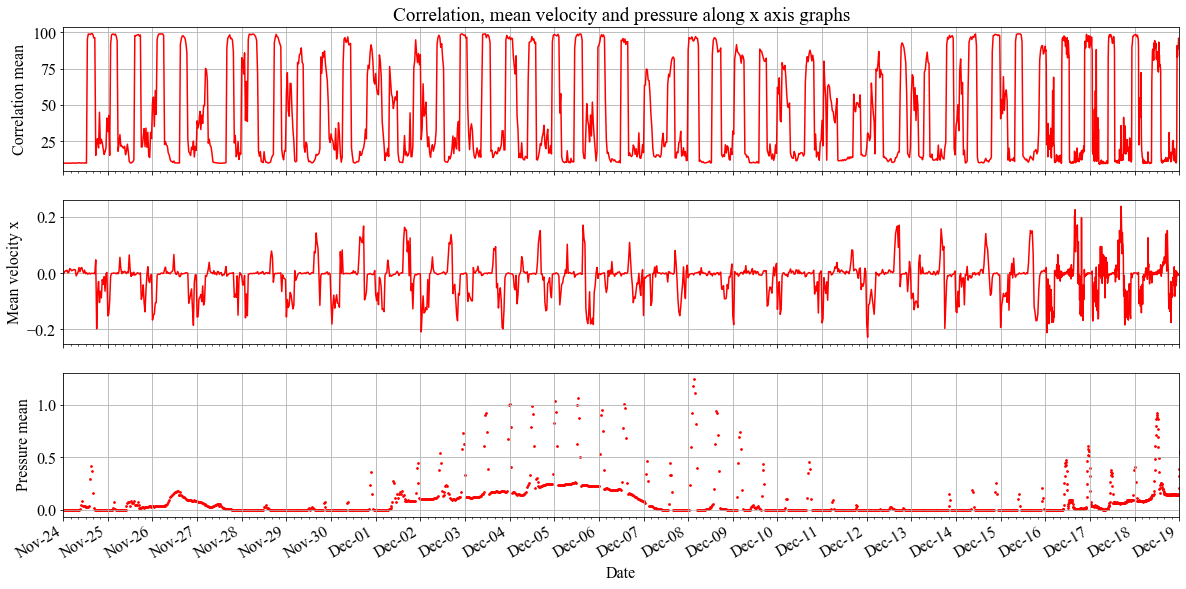

In [8]:
fig, (corr1, corr2, corr3) = plt.subplots(nrows=3, figsize=(20, 10), sharex=True)

plt.xlim([pd.to_datetime('2017-11-24'), pd.to_datetime('2017-12-19')]) # x axis limits
fmt_day = mdates.DayLocator(interval=1)
fmt_hour = mdates.HourLocator(interval=4)

corr1.plot(data_group['Date'], data_group['Correlation_1_mean'], color='red')
corr1.title.set_text('Correlation, mean velocity and pressure along x axis graphs')
corr1.set_ylabel('Correlation mean')
corr1.grid()


corr2.plot(data_group['Date'], data_group['Mean_vx'], color='red')
corr2.set_ylabel('Mean velocity x')
corr2.grid()

corr3.scatter(data_group['Date'], data_group['Pressure_mean'], s=3, color='red')
corr3.set_ylabel('Pressure mean')
corr3.set_xlabel('Date')
corr3.xaxis.set_major_locator(fmt_day)
corr3.xaxis.set_major_formatter(mdates.DateFormatter('%b-%d'))
corr3.xaxis.set_minor_locator(fmt_hour)
corr3.grid()

fig.autofmt_xdate()


Este gráfico corresponde al eje x, x+ = seaward, streamwise

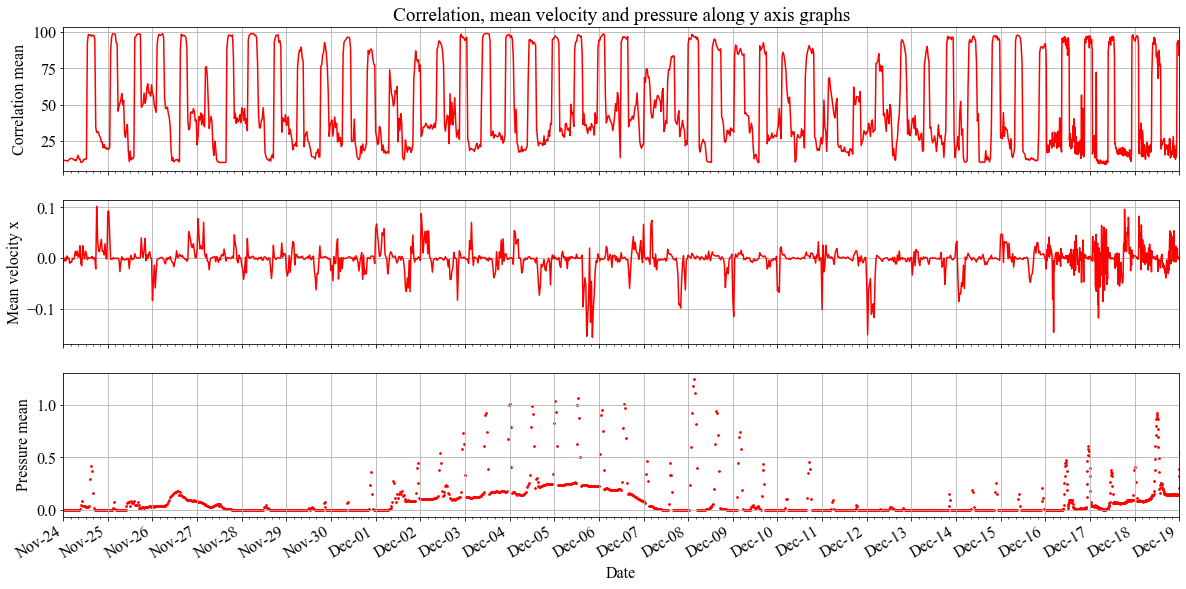

In [9]:
fig, (corr1, corr2, corr3) = plt.subplots(nrows=3, figsize=(20, 10), sharex=True)

plt.xlim([pd.to_datetime('2017-11-24'), pd.to_datetime('2017-12-19')]) # x axis limits
fmt_day = mdates.DayLocator(interval=1)
fmt_hour = mdates.HourLocator(interval=4)

corr1.plot(data_group['Date'], data_group['Correlation_2_mean'], color='red')
corr1.set_ylabel('Correlation mean')
corr1.title.set_text('Correlation, mean velocity and pressure along y axis graphs')
corr1.grid()


corr2.plot(data_group['Date'], data_group['Mean_vy'], color='red')
corr2.set_ylabel('Mean velocity x')
corr2.grid()

corr3.scatter(data_group['Date'], data_group['Pressure_mean'], s=3, color='red')
corr3.set_ylabel('Pressure mean')
corr3.set_xlabel('Date')
corr3.xaxis.set_major_locator(fmt_day)
corr3.xaxis.set_major_formatter(mdates.DateFormatter('%b-%d'))
corr3.xaxis.set_minor_locator(fmt_hour)
corr3.grid()

fig.autofmt_xdate()

Eje y es crosswise

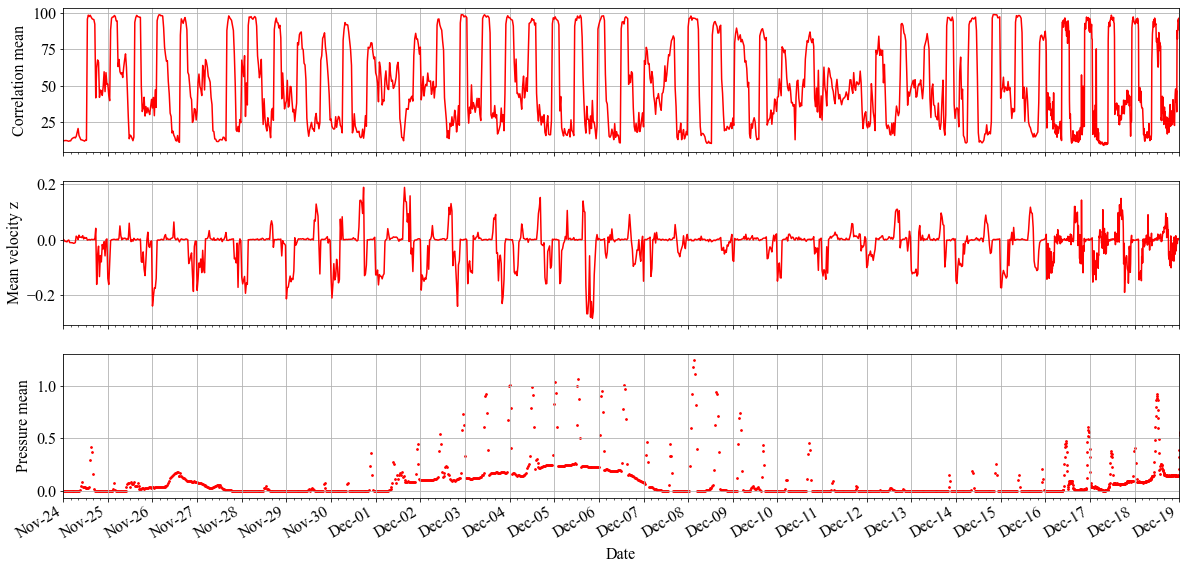

In [10]:
fig, (corr1, corr2, corr3) = plt.subplots(nrows=3, figsize=(20, 10), sharex=True)

plt.xlim([pd.to_datetime('2017-11-24'), pd.to_datetime('2017-12-19')]) # x axis limits
fmt_day = mdates.DayLocator(interval=1)
fmt_hour = mdates.HourLocator(interval=4)

corr1.plot(data_group['Date'], data_group['Correlation_3_mean'], color='red')
corr1.set_ylabel('Correlation mean')
corr1.grid()


corr2.plot(data_group['Date'], data_group['Mean_vz'], color='red')
corr2.set_ylabel('Mean velocity z')
corr2.grid()

corr3.scatter(data_group['Date'], data_group['Pressure_mean'], s=3, color='red')
corr3.set_ylabel('Pressure mean')
corr3.set_xlabel('Date')
corr3.xaxis.set_major_locator(fmt_day)
corr3.xaxis.set_major_formatter(mdates.DateFormatter('%b-%d'))
corr3.xaxis.set_minor_locator(fmt_hour)
corr3.grid()

fig.autofmt_xdate()

Lo que más llama la atención es el gráfico de presión, los peaks indican que existe una cantidad de agua significativa en ese momento. Además se puede ver un indicio de la presión atmosférica.
***
## Filtrado de datos
Cuando existe poca agua, los datos no son relevantes, por lo que surge la necesidad de filtrar estos. Para esto, se eliminaron todas las filas donde el valor de la correlación (en los 3 ejes, de manera simultánea) fuese __<85%__ (celda 12).

Por otro lado, en la celda 11 se calculó la velocidad fulctuante, restandole a cada dato la velocidad promedio del _burst_ asociado a este. Las columnas _Fluct_u, etc._ se incorporan al _dataframe_.

In [11]:
velocity_data = pd.DataFrame()
velocity_data = data_group.merge(
    all_data_drop, how="left", on="Burst_counter").sort_values(['Date', 'Ensemble_counter'])
velocity_data = velocity_data.assign(
    Fluct_u = velocity_data['Velocity_x'] - velocity_data['Mean_vx'],
    Fluct_v = velocity_data['Velocity_y'] - velocity_data['Mean_vy'],
    Fluct_w = velocity_data['Velocity_z'] - velocity_data['Mean_vz']
).drop(columns=[
    'SNR_1', 'SNR_2', 'SNR_3', 'Pressure', 'Correlation_1_mean', 'Correlation_2_mean', 'Correlation_3_mean',
    'Pressure_mean', 'Ensemble_counter', 'Amplitude_1', 'Amplitude_2', 'Amplitude_3', 'Amplitude_1_mean', 'Amplitude_2_mean', 'Amplitude_3_mean'
])
# velocidad fluctuante

In [12]:
velocity_85 = pd.DataFrame()
velocity_85 = velocity_data
velocity_85 = velocity_85.drop(velocity_85[
    (velocity_85['Correlation_1'] < 85) | (velocity_85['Correlation_2'] < 85) | (velocity_85['Correlation_3'] < 85)].index)
velocity_85.head()

,Date,Burst_counter,Mean_vx,Mean_vy,Mean_vz,Velocity_x,Velocity_y,Velocity_z,Correlation_1,Correlation_2,Correlation_3,Fluct_u,Fluct_v,Fluct_w
220800,2017-11-24 13:00:00,47,-0.002967,-0.00276,-0.001952,-0.0071,0.0472,0.0170,94,93,91,-0.004133,0.04996,0.018952
220801,2017-11-24 13:00:00,47,-0.002967,-0.00276,-0.001952,-0.0099,0.0107,0.0015,97,91,89,-0.006933,0.01346,0.003452
220802,2017-11-24 13:00:00,47,-0.002967,-0.00276,-0.001952,-0.0060,0.0129,0.0066,95,97,88,-0.003033,0.01566,0.008552
220803,2017-11-24 13:00:00,47,-0.002967,-0.00276,-0.001952,0.0064,-0.0088,0.0038,92,95,89,0.009367,-0.00604,0.005752
220804,2017-11-24 13:00:00,47,-0.002967,-0.00276,-0.001952,-0.0075,0.0075,-0.0010,93,94,91,-0.004533,0.01026,0.000952


Los datos fueron filtrados según el valor de correlación, la condición es que las 3 componentes deben ser mayores a 85% al mismo tiempo.

In [13]:
data_85_group = (
    velocity_85
    .groupby(['Burst_counter'], as_index=False)
    .agg(
        Date=("Date", 'min'),
        Velocity_x=("Velocity_x", "mean"),
        Velocity_y=("Velocity_y", "mean"),
        Velocity_z=("Velocity_z", "mean"),
        Correlation_1_mean=("Correlation_1", "mean"),
        Correlation_2_mean=("Correlation_2", "mean"),
        Correlation_3_mean=("Correlation_3", "mean"),
        
    )
)
data_85_group.head()

,Burst_counter,Date,Velocity_x,Velocity_y,Velocity_z,Correlation_1_mean,Correlation_2_mean,Correlation_3_mean
0,47,2017-11-24 13:00:00,-0.002606,-0.002532,-0.001851,96.030489,93.470307,96.423436
1,48,2017-11-24 13:30:00,-0.002110,0.001396,-0.000577,98.891227,98.241925,98.619921
2,49,2017-11-24 14:00:00,0.000943,-0.000007,0.000472,98.854758,97.703673,97.705342
3,50,2017-11-24 14:30:00,-0.002631,0.000017,-0.001666,98.507500,98.130833,98.581250
4,51,2017-11-24 15:00:00,-0.000246,0.001234,0.000325,99.033785,97.082169,97.342023


Aquí los datos fueron agrupados de la misma forma que los datos sin filtrar. El _dataframe_ _'data_85_group'_ corresponde a los datos filtrados y luego agrupados por burst, utilizando el valor promedio de cada burst. Cabe destacar que no tiene sentido obtener la velocidad fluctuante para el caso de los datos agrupados por _burst_, ya que esta sería 0.
***
## Datos del sensor de presión
Con el fin de ajustar la presión y restarle la presión atmosférica, se utilizan los datos de presión de forma directa. El proceso fue un poco tedioso, no vale la pena ahondar mucho en este. En resumen se utilizaron los datos de presión de un lugar cercano, donde prácticamente no había agua (así, se obtuvo la presión atmosférica) y esta se le restó a los datos de presión del sensor ADV.

In [14]:
pressure2_data = pd.read_csv(
    r"C:\Users\lukas\Documents\git\msc\zip\ADV_fieldFrames copy\December2017_ADVframes\Pressure\MF_060064_20171221_0950_attempt3_eng.txt",
    index_col=None,
    engine='python',
    delim_whitespace=True
)
pressure2_data.columns = [
    'Date', 'Time', 'cond05', 'temp00', 'pres09', 'pres08', 'dpth01', 'sal_00', 'scon00', 'density', 'sos_00', 'null'
]
pressure2_data['Date'] = (pressure2_data['Date'] + ' ' + pressure2_data['Time'])
pressure2_data = pressure2_data.drop(columns=['Time', 'null', 'cond05', 'density', 'sos_00'])
pressure2_data['Date'] = pd.to_datetime(pressure2_data['Date'], format='%d-%b-%Y %H:%M:%S.%f')

In [15]:
chunk_list = []
chunksize = 10 ** 5
for chunk in pd.read_csv(
    r"C:\Users\lukas\Documents\git\msc\zip\ADV_fieldFrames copy\December2017_ADVframes\Pressure\SM_051061_20171221_0721.txt",
    index_col=None,
    skiprows=28,
    engine='python',
    delim_whitespace=True,
    chunksize = chunksize):
    chunk_list.append(chunk)

df_chunk = pd.concat(chunk_list)

In [16]:
df_chunk = pd.concat(chunk_list)

In [17]:
pressure_offset_data = df_chunk
pressure_offset_data.columns = [
    'Date', 'Time', 'temp00', 'pres09', 'pres08', 'dpth01', 'null'
]
pressure_offset_data['Date'] = (pressure_offset_data['Date'] + ' ' + pressure_offset_data['Time'])
pressure_offset_data['offset_pres'] = pressure_offset_data['pres08']
pressure_offset_data = pressure_offset_data.drop(columns=['Time', 'null', 'dpth01', 'temp00', 'pres08' ,'pres09'])
pressure_offset_data['Date'] = pd.to_datetime(pressure_offset_data['Date'], format='%d-%b-%Y %H:%M:%S.%f')

Carga de datos

In [18]:
pressure_offset_data.head()

,Date,offset_pres
0,2017-11-23 14:00:00.000,-0.178259
1,2017-11-23 14:00:00.167,-0.178246
2,2017-11-23 14:00:00.333,-0.178447
3,2017-11-23 14:00:00.500,-0.177904
4,2017-11-23 14:00:00.667,-0.177930


In [19]:
merge1 = pd.merge(pressure2_data, pressure_offset_data, on=['Date'])
merge1['corr_pres'] = merge1['pres08'] - merge1['offset_pres']

Aquí se obtiene la presión del agua, descontando la presión atmosférica. Con esto se puede detectar cuándo hay suficiente agua en el humedal.

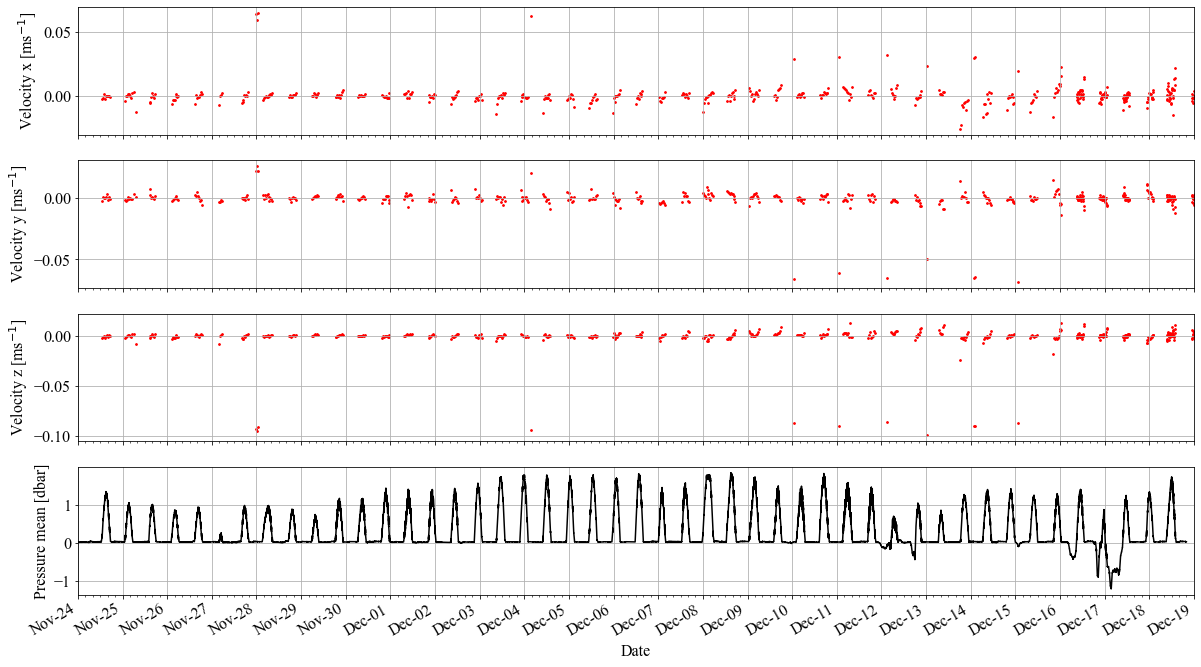

In [20]:
fig, (corr1, corr2, corr3, corr4) = plt.subplots(nrows=4, figsize=(20, 12), sharex=True)

plt.xlim([pd.to_datetime('2017-11-24'), pd.to_datetime('2017-12-19')]) # x axis limits
fmt_day = mdates.DayLocator(interval=1)
fmt_hour = mdates.HourLocator(interval=4)

corr1.scatter(data_85_group['Date'], data_85_group['Velocity_x'], color='red', s=3)
corr1.set_ylabel('Velocity x [ms$^{-1}$]')
corr1.grid()

corr2.scatter(data_85_group['Date'], data_85_group['Velocity_y'], color='red', s=3)
corr2.set_ylabel('Velocity y [ms$^{-1}$]')
corr2.grid()

corr3.scatter(data_85_group['Date'], data_85_group['Velocity_z'], color='red', s=3)
corr3.set_ylabel('Velocity z [ms$^{-1}$]')
corr3.grid()

corr4.plot(merge1['Date'], merge1['corr_pres'], color='black') # cambiar entre data_group y pressure2_data
corr4.set_ylabel('Pressure mean [dbar]')
corr4.set_xlabel('Date')
corr4.xaxis.set_major_locator(fmt_day)
corr4.xaxis.set_major_formatter(mdates.DateFormatter('%b-%d'))
corr4.xaxis.set_minor_locator(fmt_hour)
corr4.grid()


fig.autofmt_xdate()

Se puede ver que el gráfico de presión se ve mucho mejor después de realizar el ajuste, excepto entre los días 12-13 y 16-18, donde aparentemente hubo agua en los datos utilizados para el ajuste.

In [21]:
# fig, (corr1, corr2) = plt.subplots(nrows=2, figsize=(20, 10), sharex=True)

# plt.xlim([pd.to_datetime('2017-12-08'), pd.to_datetime('2017-12-10')]) # x axis limits
# fmt_day = mdates.DayLocator(interval=1)
# fmt_hour = mdates.HourLocator(interval=4)

# corr1.scatter(velocity_group_85['Date'], velocity_group_85['Mean_velocity'], color='red', s=15)
# corr1.set_ylabel('Mean Velocity')
# corr1.grid()

# corr2.plot(data_group['Date'], data_group['Pressure_mean'], color='black')
# corr2.set_ylabel('Pressure mean')
# corr2.set_xlabel('Date')
# corr2.xaxis.set_major_locator(fmt_day)
# corr2.xaxis.set_major_formatter(mdates.DateFormatter('%b-%d'))
# corr2.xaxis.set_minor_locator(fmt_hour)
# corr2.grid()

# fig.autofmt_xdate()

Se acotan los valores de velocidad, entre -.05 y .05 m/s (REVISAR), luego se vuelven a graficar.

In [22]:
data_85_group['Velocity_x'].values[data_85_group['Velocity_x'] > 0.05] = np.nan
data_85_group['Velocity_x'].values[data_85_group['Velocity_x'] < -0.05] = np.nan
data_85_group['Velocity_y'].values[data_85_group['Velocity_y'] > 0.05] = np.nan
data_85_group['Velocity_y'].values[data_85_group['Velocity_y'] < -0.05] = np.nan
data_85_group['Velocity_z'].values[data_85_group['Velocity_z'] > 0.05] = np.nan
data_85_group['Velocity_z'].values[data_85_group['Velocity_z'] < -0.05] = np.nan

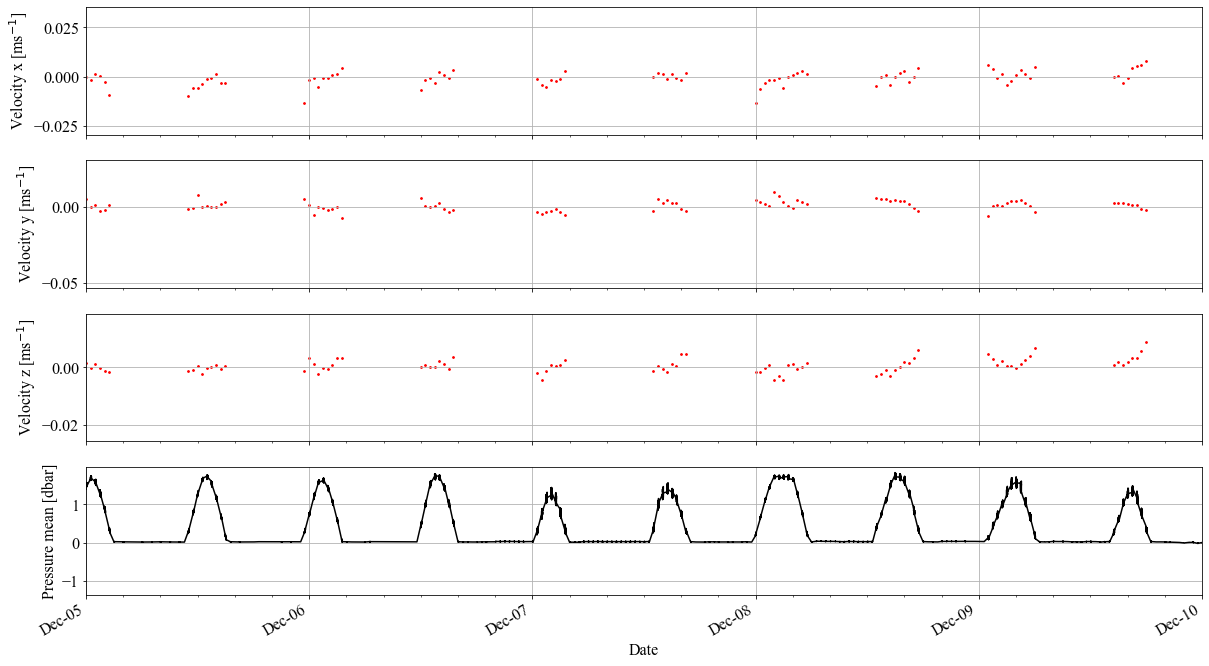

In [23]:
fig2, (corr1, corr2, corr3, corr4) = plt.subplots(nrows=4, figsize=(20, 12), sharex=True)

plt.xlim([pd.to_datetime('2017-12-05'), pd.to_datetime('2017-12-10')]) # x axis limits
fmt_day = mdates.DayLocator(interval=1)
fmt_hour = mdates.HourLocator(interval=4)

corr1.scatter(data_85_group['Date'], data_85_group['Velocity_x'], color='red', s=3)
corr1.set_ylabel('Velocity x [ms$^{-1}$]')
corr1.grid()

corr2.scatter(data_85_group['Date'], data_85_group['Velocity_y'], color='red', s=3)
corr2.set_ylabel('Velocity y [ms$^{-1}$]')
corr2.grid()

corr3.scatter(data_85_group['Date'], data_85_group['Velocity_z'], color='red', s=3)
corr3.set_ylabel('Velocity z [ms$^{-1}$]')
corr3.grid()

corr4.plot(merge1['Date'], merge1['corr_pres'], color='black') # cambiar entre data_group y pressure2_data
corr4.set_ylabel('Pressure mean [dbar]')
corr4.set_xlabel('Date')
corr4.xaxis.set_major_locator(fmt_day)
corr4.xaxis.set_major_formatter(mdates.DateFormatter('%b-%d'))
corr4.xaxis.set_minor_locator(fmt_hour)
corr4.grid()

fig2.autofmt_xdate()

Se grafica escogiendo un rango acotado de fechas, para el caso entre el 5 y 10 de diciembre.

### Burst (elegir)

In [24]:
burst_inicial = 549
burst_final = 596
velocity_85_burst = (
    velocity_85.loc[lambda x: burst_inicial <= x["Burst_counter"]].loc[lambda x: x["Burst_counter"] <= burst_final]
#     .reset_index().drop(columns=["index", "Mean_vx", "Mean_vy", "Mean_vz", "Velocity_x", "Velocity_y", "Velocity_z"])
)
velocity_85_burst

,Date,Burst_counter,Mean_vx,Mean_vy,Mean_vz,Velocity_x,Velocity_y,Velocity_z,Correlation_1,Correlation_2,Correlation_3,Fluct_u,Fluct_v,Fluct_w
2630400,2017-12-05 00:00:00,549,-0.000400,0.004831,0.001641,0.0015,0.0080,0.0032,99,95,98,0.001900,0.003169,0.001559
2630401,2017-12-05 00:00:00,549,-0.000400,0.004831,0.001641,-0.0048,0.0049,-0.0004,99,97,98,-0.004400,0.000069,-0.002041
2630402,2017-12-05 00:00:00,549,-0.000400,0.004831,0.001641,-0.0045,0.0031,-0.0012,99,97,98,-0.004100,-0.001731,-0.002841
2630403,2017-12-05 00:00:00,549,-0.000400,0.004831,0.001641,0.0027,0.0041,0.0030,99,94,98,0.003100,-0.000731,0.001359
2630404,2017-12-05 00:00:00,549,-0.000400,0.004831,0.001641,-0.0043,0.0087,0.0013,99,96,98,-0.003900,0.003869,-0.000341
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2860795,2017-12-05 23:30:00,596,-0.018213,0.008658,-0.001015,-0.0134,0.0088,0.0004,95,97,95,0.004813,0.000142,0.001415
2860796,2017-12-05 23:30:00,596,-0.018213,0.008658,-0.001015,-0.0149,0.0123,-0.0011,96,95,94,0.003313,0.003642,-0.000085
2860797,2017-12-05 23:30:00,596,-0.018213,0.008658,-0.001015,-0.0046,0.0042,0.0003,91,93,89,0.013613,-0.004458,0.001315
2860798,2017-12-05 23:30:00,596,-0.018213,0.008658,-0.001015,-0.0207,-0.0012,-0.0075,94,97,93,-0.002487,-0.009858,-0.006485


### Esfuerzo de Reynolds (bed shear stress)

Aquí se calculan las velocidades fluctuantes uw y vw, se crea un nuevo dataframe con el esfuerzo de reynolds y U*.

(falta agregar referencia de la fórmula usada)

In [25]:
velocity_85['Fluct_uw'] = velocity_85['Fluct_u'] * velocity_85['Fluct_w']
velocity_85['Fluct_vw'] = velocity_85['Fluct_v'] * velocity_85['Fluct_w']
data_rey = velocity_85
data_rey['Tau Re'] = 1000 * np.sqrt(data_rey['Fluct_uw'] ** 2 + data_rey['Fluct_vw'] ** 2)
data_rey['U*'] = np.sqrt(data_rey['Tau Re']/1000)
data_rey

,Date,Burst_counter,Mean_vx,Mean_vy,Mean_vz,Velocity_x,Velocity_y,Velocity_z,Correlation_1,Correlation_2,Correlation_3,Fluct_u,Fluct_v,Fluct_w,Fluct_uw,Fluct_vw,Tau Re,U*
220800,2017-11-24 13:00:00,47,-0.002967,-0.002760,-0.001952,-0.0071,0.0472,0.0170,94,93,91,-0.004133,0.049960,0.018952,-0.000078,0.000947,0.950105,0.030824
220801,2017-11-24 13:00:00,47,-0.002967,-0.002760,-0.001952,-0.0099,0.0107,0.0015,97,91,89,-0.006933,0.013460,0.003452,-0.000024,0.000046,0.052273,0.007230
220802,2017-11-24 13:00:00,47,-0.002967,-0.002760,-0.001952,-0.0060,0.0129,0.0066,95,97,88,-0.003033,0.015660,0.008552,-0.000026,0.000134,0.136423,0.011680
220803,2017-11-24 13:00:00,47,-0.002967,-0.002760,-0.001952,0.0064,-0.0088,0.0038,92,95,89,0.009367,-0.006040,0.005752,0.000054,-0.000035,0.064112,0.008007
220804,2017-11-24 13:00:00,47,-0.002967,-0.002760,-0.001952,-0.0075,0.0075,-0.0010,93,94,91,-0.004533,0.010260,0.000952,-0.000004,0.000010,0.010683,0.003269
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5609870,2017-12-20 21:06:42,1622,-0.002172,-0.000762,0.000171,0.0143,-0.0065,0.0030,87,85,85,0.016472,-0.005738,0.002829,0.000047,-0.000016,0.049341,0.007024
5609888,2017-12-20 21:06:42,1622,-0.002172,-0.000762,0.000171,0.0061,-0.0031,-0.0017,85,85,86,0.008272,-0.002338,-0.001871,-0.000015,0.000004,0.016086,0.004011
5609905,2017-12-20 21:06:42,1622,-0.002172,-0.000762,0.000171,0.0075,0.0021,-0.0034,85,87,85,0.009672,0.002862,-0.003571,-0.000035,-0.000010,0.036024,0.006002
5609938,2017-12-20 21:06:42,1622,-0.002172,-0.000762,0.000171,0.0108,0.0089,-0.0090,86,86,85,0.012972,0.009662,-0.009171,-0.000119,-0.000089,0.148349,0.012180


Luego, promediando por burst.

In [26]:
data_group_rey = (
    velocity_85
    .groupby(['Burst_counter'], as_index=False)
    .agg(
        Fluct_uw=("Fluct_uw", "mean"),
        Fluct_vw=("Fluct_vw", "mean")
    )
)
data_group_rey['Tau Re'] = 1000 * np.sqrt(data_group_rey['Fluct_uw'] ** 2 + data_group_rey['Fluct_vw'] ** 2)
data_group_rey['U*'] = np.sqrt(data_group_rey['Tau Re']/1000)
data_group_rey

,Burst_counter,Fluct_uw,Fluct_vw,Tau Re,U*
0,47,0.000040,0.000024,0.046725,0.006836
1,48,0.000007,0.000006,0.008857,0.002976
2,49,0.000007,0.000008,0.010713,0.003273
3,50,0.000006,0.000002,0.006752,0.002598
4,51,0.000005,0.000007,0.008116,0.002849
...,...,...,...,...,...
506,1503,0.000201,-0.000174,0.265710,0.016301
507,1504,0.000176,-0.000179,0.251282,0.015852
508,1505,0.000148,-0.000120,0.190841,0.013815
509,1506,0.000106,-0.000081,0.133714,0.011563


### Tau TKE

Se calcula tau mediante la energía cinética turbulenta, creando un dataframe asociado (data_group_tke) con los bursts promediados.

In [27]:
velocity_85['Fluct $u^2$'] = velocity_85['Fluct_u'] * velocity_85['Fluct_u']
velocity_85['Fluct $v^2$'] = velocity_85['Fluct_v'] * velocity_85['Fluct_v']
velocity_85['Fluct $w^2$'] = velocity_85['Fluct_w'] * velocity_85['Fluct_w']

data_group_tke = (
    velocity_85
    .groupby(['Burst_counter'], as_index=False)
    .agg(
        Fluct_u2_mean=("Fluct $u^2$", "mean"),
        Fluct_v2_mean=("Fluct $v^2$", "mean"),
        Fluct_w2_mean=("Fluct $w^2$", "mean")
    )
)

data_group_tke['TKE'] = (data_group_tke['Fluct_u2_mean'] + data_group_tke['Fluct_v2_mean'] + data_group_tke['Fluct_w2_mean']) * 0.5
data_group_tke['Tau TKE'] = 1000 * 0.21 * data_group_tke['TKE'] # rho y coeficiente entre 0.19 y 0.21
data_group_tke

,Burst_counter,Fluct_u2_mean,Fluct_v2_mean,Fluct_w2_mean,TKE,Tau TKE
0,47,0.000066,0.000078,0.000031,0.000088,0.018473
1,48,0.000010,0.000017,0.000006,0.000017,0.003516
2,49,0.000015,0.000033,0.000007,0.000028,0.005788
3,50,0.000013,0.000021,0.000006,0.000020,0.004172
4,51,0.000010,0.000021,0.000004,0.000018,0.003814
...,...,...,...,...,...,...
506,1503,0.000461,0.000207,0.000166,0.000417,0.087647
507,1504,0.000450,0.000224,0.000162,0.000418,0.087788
508,1505,0.000322,0.000129,0.000150,0.000301,0.063124
509,1506,0.000270,0.000115,0.000100,0.000243,0.050981


### LP Method

Se utiliza el método de perfil logarítmico para obtener U*. Dataframe asociado (velocity_85_LP).

(referenciar)

In [28]:
velocity_85_LP = velocity_85
velocity_85_LP['Velocity_U'] = np.sqrt(velocity_85['Velocity_x'] ** 2 + velocity_85['Velocity_y'] ** 2)
velocity_85_LP = velocity_85_LP.reset_index().drop(
    columns=["index", "Fluct_u", "Fluct_v", "Fluct_w", "Mean_vx", "Mean_vy", "Mean_vz", "Fluct_uw", "Fluct_vw", "Fluct $u^2$", "Fluct $w^2$", "Fluct $v^2$"]
)
velocity_85_LP

,Date,Burst_counter,Velocity_x,Velocity_y,Velocity_z,Correlation_1,Correlation_2,Correlation_3,Tau Re,U*,Velocity_U
0,2017-11-24 13:00:00,47,-0.0071,0.0472,0.0170,94,93,91,0.950105,0.030824,0.047731
1,2017-11-24 13:00:00,47,-0.0099,0.0107,0.0015,97,91,89,0.052273,0.007230,0.014577
2,2017-11-24 13:00:00,47,-0.0060,0.0129,0.0066,95,97,88,0.136423,0.011680,0.014227
3,2017-11-24 13:00:00,47,0.0064,-0.0088,0.0038,92,95,89,0.064112,0.008007,0.010881
4,2017-11-24 13:00:00,47,-0.0075,0.0075,-0.0010,93,94,91,0.010683,0.003269,0.010607
...,...,...,...,...,...,...,...,...,...,...,...
1138946,2017-12-20 21:06:42,1622,0.0143,-0.0065,0.0030,87,85,85,0.049341,0.007024,0.015708
1138947,2017-12-20 21:06:42,1622,0.0061,-0.0031,-0.0017,85,85,86,0.016086,0.004011,0.006843
1138948,2017-12-20 21:06:42,1622,0.0075,0.0021,-0.0034,85,87,85,0.036024,0.006002,0.007788
1138949,2017-12-20 21:06:42,1622,0.0108,0.0089,-0.0090,86,86,85,0.148349,0.012180,0.013995


In [29]:
data_group_LP = (
    velocity_85_LP
    .groupby(['Burst_counter'], as_index=False)
    .agg(
        Velocity_U_mean=("Velocity_U", "mean"),
        Velocity_u_mean=("Velocity_x", "mean")
    )
)
data_group_LP['U*'] = (data_group_LP['Velocity_U_mean'] * 0.4) / (np.log(150/0.2)) # Von karman 0.4, altura z 15 centímetros, zo = 0.2 mm 
data_group_LP['Tau_LP'] = 1000 * data_group_LP['U*'] ** 2
data_group_LP['U*_u'] = (data_group_LP['Velocity_u_mean'] * 0.4) / (np.log(150/0.2)) # Von karman 0.4, altura z 15 centímetros, 
data_group_LP['Tau_LP_u'] = 1000 * data_group_LP['U*_u'] ** 2
data_group_LP

,Burst_counter,Velocity_U_mean,Velocity_u_mean,U*,Tau_LP,U*_u,Tau_LP_u
0,47,0.010181,-0.002606,0.000615,0.000378,-0.000157,2.479350e-05
1,48,0.004769,-0.002110,0.000288,0.000083,-0.000127,1.625111e-05
2,49,0.005091,0.000943,0.000308,0.000095,0.000057,3.249743e-06
3,50,0.005423,-0.002631,0.000328,0.000107,-0.000159,2.527019e-05
4,51,0.004639,-0.000246,0.000280,0.000079,-0.000015,2.206467e-07
...,...,...,...,...,...,...,...
506,1503,0.021847,0.000155,0.001320,0.001742,0.000009,8.744249e-08
507,1504,0.023420,0.006745,0.001415,0.002002,0.000408,1.660846e-04
508,1505,0.020344,0.005078,0.001229,0.001511,0.000307,9.414585e-05
509,1506,0.023930,0.013892,0.001446,0.002091,0.000839,7.046204e-04


### Hydrodynamic Roughness $z_o$
1. Bed shear stress con Reynolds
2. Calcular velocidad de fricción ($U^*$)
3. Calcular $z_o$ con LP

In [30]:
hr_data = pd.DataFrame()
hr_data = data_group_rey
hr_data['U_mean'] = data_group_LP['Velocity_U_mean'] 
hr_data['zo'] = 150/(np.exp(hr_data['U_mean'] * 0.4 / hr_data['U*']))
hr_data

,Burst_counter,Fluct_uw,Fluct_vw,Tau Re,U*,U_mean,zo
0,47,0.000040,0.000024,0.046725,0.006836,0.010181,82.669359
1,48,0.000007,0.000006,0.008857,0.002976,0.004769,79.013774
2,49,0.000007,0.000008,0.010713,0.003273,0.005091,80.514910
3,50,0.000006,0.000002,0.006752,0.002598,0.005423,65.091770
4,51,0.000005,0.000007,0.008116,0.002849,0.004639,78.202318
...,...,...,...,...,...,...,...
506,1503,0.000201,-0.000174,0.265710,0.016301,0.021847,87.754185
507,1504,0.000176,-0.000179,0.251282,0.015852,0.023420,83.069142
508,1505,0.000148,-0.000120,0.190841,0.013815,0.020344,83.227494
509,1506,0.000106,-0.000081,0.133714,0.011563,0.023930,65.552648


In [31]:
hr_data.describe()

,Burst_counter,Fluct_uw,Fluct_vw,Tau Re,U*,U_mean,zo
count,511.000000,511.000000,511.000000,511.000000,511.000000,511.000000,511.000000
mean,772.121331,0.000139,-0.000039,0.191138,0.009816,0.014568,77.188010
std,422.377437,0.000698,0.000277,0.740567,0.009745,0.009921,14.948111
min,47.000000,-0.003798,-0.001565,0.002421,0.001556,0.002973,8.472014
25%,422.500000,0.000013,-0.000088,0.023363,0.004834,0.008778,67.018145
50%,770.000000,0.000040,-0.000021,0.062974,0.007936,0.013548,78.516599
75%,1135.500000,0.000096,0.000007,0.138249,0.011758,0.018103,86.637258
max,1622.000000,0.010395,0.003623,10.504504,0.102491,0.073264,143.540325


Seguir con:

Drag coefficient

Scatter plot de la velocidad